In [1]:
import pandas as pd
from numpy import random
import numpy as np
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2

from matplotlib import pyplot as plt
from lib.noglobal import noglobal


from lib.evolutionary_computation.GA import exe_GA,initialize_population
from lib.evolutionary_computation.Problem import onemaxProblem,zeromaxProblem,knapsackProblem

from lib.evolutionary_computation.Solution import Solution, population_to_numpy
from lib.evolutionary_computation.Problem import Problem



## deepsort 

In [2]:
deepsort_result = pd.read_csv("deepsort_result.csv")

deepsort_result = deepsort_result.dropna(subset = ["deepsort_cluster"])
target_video ="_".join(deepsort_result["video"].unique()[0].split("_")[:-1])


deepsort_result = deepsort_result[deepsort_result["frame"] < 5]
    

In [3]:
deepsort_result

,index,video_frame,left,width,top,height,conf,frame,video,x,y,top_deepsort,deepsort_cluster,right,bottom,average_pixel_r,average_pixel_g,average_pixel_b,team
30,38,57778_004244_Endzone_3,303,21,278,21,0.825195,3,57778_004244_Endzone,313.0,288.0,277.0,1.0,324,299,87.612245,80.918367,84.306122,1
31,48,57778_004244_Endzone_3,378,24,266,21,0.875000,3,57778_004244_Endzone,390.0,276.0,265.0,7.0,402,287,49.892857,47.321429,47.875000,1
32,41,57778_004244_Endzone_3,390,22,166,26,0.856445,3,57778_004244_Endzone,401.0,179.0,166.0,2.0,412,192,246.111111,246.904762,246.873016,0
33,40,57778_004244_Endzone_3,479,18,297,16,0.836426,3,57778_004244_Endzone,488.0,305.0,296.0,13.0,497,313,74.400000,72.933333,80.866667,1
34,47,57778_004244_Endzone_3,546,22,268,28,0.875000,3,57778_004244_Endzone,557.0,282.0,268.0,8.0,568,296,249.650794,249.825397,251.571429,0
35,49,57778_004244_Endzone_3,553,21,511,22,0.878906,3,57778_004244_Endzone,563.0,522.0,510.0,5.0,574,533,41.510204,43.755102,46.795918,1
36,39,57778_004244_Endzone_3,585,19,290,19,0.833008,3,57778_004244_Endzone,595.0,300.0,290.0,14.0,604,309,42.777778,42.027778,41.000000,1
37,50,57778_004244_Endzone_3,624,22,117,27,0.884766,3,57778_004244_Endzone,635.0,131.0,116.0,6.0,646,144,208.873016,207.000000,209.904762,0
38,36,57778_004244_Endzone_3,648,18,190,23,0.213257,3,57778_004244_Endzone,657.0,202.0,116.0,6.0,666,213,163.812500,99.875000,108.916667,1
39,37,57778_004244_Endzone_3,683,23,152,29,0.799316,3,57778_004244_Endzone,695.0,166.0,151.0,12.0,706,181,228.012500,225.250000,225.575000,0


## tracking

In [4]:
from external_lib.utility import add_track_features


@noglobal()
def preprocess_tracking(target_video):
    tracking = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/train_player_tracking.csv")
    tracking = add_track_features(tracking)
    tracking = tracking[tracking["game_play"] == target_video]
    tracking = tracking[tracking["est_frame"] >-5]
    return tracking.reset_index()

tracking = preprocess_tracking(target_video)

## solution variables

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
deepsort_result["deepsort_cluster_label"] = deepsort_result["deepsort_cluster"].apply(lambda x: "cluster_"+str(x))
le.fit(deepsort_result["deepsort_cluster_label"])

deepsort_result["deepsort_cluster_encoded"] = le.transform(deepsort_result["deepsort_cluster_label"])
pd_list = [];
pd_list  = [each_df[~each_df["deepsort_cluster_encoded"].duplicated()] for key,each_df in  deepsort_result.groupby("frame")]
deepsort_result = pd.concat(pd_list)


H_player =tracking.loc[tracking["player"].str.contains("H"),"player"].unique()
V_player =tracking.loc[tracking["player"].str.contains("V"),"player"].unique()

n_variables = deepsort_result["deepsort_cluster_encoded"].nunique()

n_H_player = H_player.shape[0]
n_V_player = V_player.shape[0]

solution_variables = random.randint(n_V_player+n_H_player,size = n_variables)
solution_variables = solution_variables-n_V_player
solution_variables = np.where(solution_variables>=0,solution_variables+1,solution_variables)

## team

### prepare

### main

In [6]:
from lib.evolutionary_computation.Compe_Problem import team_count,Distance_Evaluator, Same_Person_Per_Frame_Evaluator,Compe_problem

team_count(solution_variables,deepsort_result)

-2

## Distance minimization

In [7]:

            
                                
eva = Distance_Evaluator(deepsort_result,tracking,H_player,V_player,isNorm=True)           
for k in tqdm(range(1)):
    solution_variables = random.randint(n_V_player+n_H_player,size = n_variables)
    solution_variables = solution_variables-n_V_player
    solution_variables = np.where(solution_variables>=0,solution_variables+1,solution_variables)
    b = eva.evaluate(solution_variables)
    #print(b)
#solution_variables


100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


## 同一フレームに同一人物が復数いないようにする。

In [8]:
deepsort_result

,index,video_frame,left,width,top,height,conf,frame,video,x,...,top_deepsort,deepsort_cluster,right,bottom,average_pixel_r,average_pixel_g,average_pixel_b,team,deepsort_cluster_label,deepsort_cluster_encoded
30,38,57778_004244_Endzone_3,303,21,278,21,0.825195,3,57778_004244_Endzone,313.0,...,277.0,1.0,324,299,87.612245,80.918367,84.306122,1,cluster_1.0,0
31,48,57778_004244_Endzone_3,378,24,266,21,0.875000,3,57778_004244_Endzone,390.0,...,265.0,7.0,402,287,49.892857,47.321429,47.875000,1,cluster_7.0,12
32,41,57778_004244_Endzone_3,390,22,166,26,0.856445,3,57778_004244_Endzone,401.0,...,166.0,2.0,412,192,246.111111,246.904762,246.873016,0,cluster_2.0,7
33,40,57778_004244_Endzone_3,479,18,297,16,0.836426,3,57778_004244_Endzone,488.0,...,296.0,13.0,497,313,74.400000,72.933333,80.866667,1,cluster_13.0,4
34,47,57778_004244_Endzone_3,546,22,268,28,0.875000,3,57778_004244_Endzone,557.0,...,268.0,8.0,568,296,249.650794,249.825397,251.571429,0,cluster_8.0,13
35,49,57778_004244_Endzone_3,553,21,511,22,0.878906,3,57778_004244_Endzone,563.0,...,510.0,5.0,574,533,41.510204,43.755102,46.795918,1,cluster_5.0,10
36,39,57778_004244_Endzone_3,585,19,290,19,0.833008,3,57778_004244_Endzone,595.0,...,290.0,14.0,604,309,42.777778,42.027778,41.000000,1,cluster_14.0,5
37,50,57778_004244_Endzone_3,624,22,117,27,0.884766,3,57778_004244_Endzone,635.0,...,116.0,6.0,646,144,208.873016,207.000000,209.904762,0,cluster_6.0,11
39,37,57778_004244_Endzone_3,683,23,152,29,0.799316,3,57778_004244_Endzone,695.0,...,151.0,12.0,706,181,228.012500,225.250000,225.575000,0,cluster_12.0,3
40,42,57778_004244_Endzone_3,694,20,301,17,0.857422,3,57778_004244_Endzone,704.0,...,300.0,11.0,714,318,80.952381,85.119048,85.809524,1,cluster_11.0,2


In [9]:
eva = Same_Person_Per_Frame_Evaluator(deepsort_result)           
for k in tqdm(range(1)):    
    
    solution_variables = random.randint(n_V_player+n_H_player,size = n_variables)
    solution_variables = solution_variables-n_V_player
    solution_variables = np.where(solution_variables>=0,solution_variables+1,solution_variables)
    b = eva.evaluate(solution_variables)
    #print(b)

100%|██████████| 1/1 [00:00<00:00, 470.27it/s]


In [10]:
deepsort_result.head(3)

,index,video_frame,left,width,top,height,conf,frame,video,x,...,top_deepsort,deepsort_cluster,right,bottom,average_pixel_r,average_pixel_g,average_pixel_b,team,deepsort_cluster_label,deepsort_cluster_encoded
30,38,57778_004244_Endzone_3,303,21,278,21,0.825195,3,57778_004244_Endzone,313.0,...,277.0,1.0,324,299,87.612245,80.918367,84.306122,1,cluster_1.0,0
31,48,57778_004244_Endzone_3,378,24,266,21,0.875000,3,57778_004244_Endzone,390.0,...,265.0,7.0,402,287,49.892857,47.321429,47.875000,1,cluster_7.0,12
32,41,57778_004244_Endzone_3,390,22,166,26,0.856445,3,57778_004244_Endzone,401.0,...,166.0,2.0,412,192,246.111111,246.904762,246.873016,0,cluster_2.0,7


In [11]:
pd_list  = [ each_df[~each_df["deepsort_cluster_encoded"].duplicated()] for key,each_df in  deepsort_result.groupby("frame")]
test = pd.concat(pd_list)
test["dummy"] = 1
b = test.pivot(index="frame",columns = "deepsort_cluster_encoded",values = "dummy").fillna(0)
sol = solution_variables
s = b.copy()


In [12]:
%%time

(b*sol).T.nunique().sum()

CPU times: user 1.88 ms, sys: 352 µs, total: 2.23 ms
Wall time: 2.15 ms


22

## Problem

In [13]:
%%time

B,objective,best_solution = exe_GA(Compe_problem(tracking.reset_index(drop=True),deepsort_result.reset_index(drop=True)))

100%|██████████| 500/500 [02:53<00:00,  2.88it/s]

CPU times: user 1min 46s, sys: 59.6 s, total: 2min 46s
Wall time: 2min 53s


In [14]:
best_solution.variables

array([-1, 11,  5, -7,  8, 10, -3,  7,  4, -2, -4, -9, -8, -5,  2])

In [15]:
home = np.where(best_solution.variables > 0)[0]
visitor = np.where(best_solution.variables < 0)[0]

In [16]:
modify = deepsort_result.copy()

In [17]:
def _get_Player(variable,H_player_list,V_player_list):
        
        #best_solution.problem.H_player_list
        if (variable > 0):
            return H_player_list[variable-1]
        else:
            return V_player_list[abs(variable)-1]
        

H_player_list = best_solution.problem.H_player_list
V_player_list = best_solution.problem.V_player_list
        
modify["player"] = modify["deepsort_cluster_encoded"].apply(lambda x: _get_Player(best_solution.variables[x],H_player_list,V_player_list));

In [18]:
modify.loc[modify["deepsort_cluster_encoded"].isin(home),"Optimized_Team"] = "Home"
modify.loc[modify["deepsort_cluster_encoded"].isin(visitor),"Optimized_Team"] = "Visitor"
modify = modify.reset_index(drop=True)
modify

,index,video_frame,left,width,top,height,conf,frame,video,x,...,right,bottom,average_pixel_r,average_pixel_g,average_pixel_b,team,deepsort_cluster_label,deepsort_cluster_encoded,player,Optimized_Team
0,38,57778_004244_Endzone_3,303,21,278,21,0.825195,3,57778_004244_Endzone,313.0,...,324,299,87.612245,80.918367,84.306122,1,cluster_1.0,0,V98,Visitor
1,48,57778_004244_Endzone_3,378,24,266,21,0.875000,3,57778_004244_Endzone,390.0,...,402,287,49.892857,47.321429,47.875000,1,cluster_7.0,12,V26,Visitor
2,41,57778_004244_Endzone_3,390,22,166,26,0.856445,3,57778_004244_Endzone,401.0,...,412,192,246.111111,246.904762,246.873016,0,cluster_2.0,7,H71,Home
3,40,57778_004244_Endzone_3,479,18,297,16,0.836426,3,57778_004244_Endzone,488.0,...,497,313,74.400000,72.933333,80.866667,1,cluster_13.0,4,H85,Home
4,47,57778_004244_Endzone_3,546,22,268,28,0.875000,3,57778_004244_Endzone,557.0,...,568,296,249.650794,249.825397,251.571429,0,cluster_8.0,13,V33,Visitor
5,49,57778_004244_Endzone_3,553,21,511,22,0.878906,3,57778_004244_Endzone,563.0,...,574,533,41.510204,43.755102,46.795918,1,cluster_5.0,10,V51,Visitor
6,39,57778_004244_Endzone_3,585,19,290,19,0.833008,3,57778_004244_Endzone,595.0,...,604,309,42.777778,42.027778,41.000000,1,cluster_14.0,5,H18,Home
7,50,57778_004244_Endzone_3,624,22,117,27,0.884766,3,57778_004244_Endzone,635.0,...,646,144,208.873016,207.000000,209.904762,0,cluster_6.0,11,V43,Visitor
8,37,57778_004244_Endzone_3,683,23,152,29,0.799316,3,57778_004244_Endzone,695.0,...,706,181,228.012500,225.250000,225.575000,0,cluster_12.0,3,V96,Visitor
9,42,57778_004244_Endzone_3,694,20,301,17,0.857422,3,57778_004244_Endzone,704.0,...,714,318,80.952381,85.119048,85.809524,1,cluster_11.0,2,H73,Home


In [19]:
modify

,index,video_frame,left,width,top,height,conf,frame,video,x,...,right,bottom,average_pixel_r,average_pixel_g,average_pixel_b,team,deepsort_cluster_label,deepsort_cluster_encoded,player,Optimized_Team
0,38,57778_004244_Endzone_3,303,21,278,21,0.825195,3,57778_004244_Endzone,313.0,...,324,299,87.612245,80.918367,84.306122,1,cluster_1.0,0,V98,Visitor
1,48,57778_004244_Endzone_3,378,24,266,21,0.875000,3,57778_004244_Endzone,390.0,...,402,287,49.892857,47.321429,47.875000,1,cluster_7.0,12,V26,Visitor
2,41,57778_004244_Endzone_3,390,22,166,26,0.856445,3,57778_004244_Endzone,401.0,...,412,192,246.111111,246.904762,246.873016,0,cluster_2.0,7,H71,Home
3,40,57778_004244_Endzone_3,479,18,297,16,0.836426,3,57778_004244_Endzone,488.0,...,497,313,74.400000,72.933333,80.866667,1,cluster_13.0,4,H85,Home
4,47,57778_004244_Endzone_3,546,22,268,28,0.875000,3,57778_004244_Endzone,557.0,...,568,296,249.650794,249.825397,251.571429,0,cluster_8.0,13,V33,Visitor
5,49,57778_004244_Endzone_3,553,21,511,22,0.878906,3,57778_004244_Endzone,563.0,...,574,533,41.510204,43.755102,46.795918,1,cluster_5.0,10,V51,Visitor
6,39,57778_004244_Endzone_3,585,19,290,19,0.833008,3,57778_004244_Endzone,595.0,...,604,309,42.777778,42.027778,41.000000,1,cluster_14.0,5,H18,Home
7,50,57778_004244_Endzone_3,624,22,117,27,0.884766,3,57778_004244_Endzone,635.0,...,646,144,208.873016,207.000000,209.904762,0,cluster_6.0,11,V43,Visitor
8,37,57778_004244_Endzone_3,683,23,152,29,0.799316,3,57778_004244_Endzone,695.0,...,706,181,228.012500,225.250000,225.575000,0,cluster_12.0,3,V96,Visitor
9,42,57778_004244_Endzone_3,694,20,301,17,0.857422,3,57778_004244_Endzone,704.0,...,714,318,80.952381,85.119048,85.809524,1,cluster_11.0,2,H73,Home


train_df = pd.read_csv("/work/data/input/nfl-health-and-safety-helmet-assignment/train_labels.csv")
train_df["video"] = train_df["video_frame"].apply(lambda x: "_".join(x.split("_")[:-1]))

train_df = train_df[train_df["video"].isin(["57778_004244_Endzone"])]
train_df["right"] = train_df["left"] + train_df["width"]
train_df["bottom"] = train_df["top"] + train_df["height"]
display(train_df)

In [20]:
a = np.array([ i for i in range(1,200)])
s = a / sum(a)
s[::-1]

array([1.00000000e-02, 9.94974874e-03, 9.89949749e-03, 9.84924623e-03,
       9.79899497e-03, 9.74874372e-03, 9.69849246e-03, 9.64824121e-03,
       9.59798995e-03, 9.54773869e-03, 9.49748744e-03, 9.44723618e-03,
       9.39698492e-03, 9.34673367e-03, 9.29648241e-03, 9.24623116e-03,
       9.19597990e-03, 9.14572864e-03, 9.09547739e-03, 9.04522613e-03,
       8.99497487e-03, 8.94472362e-03, 8.89447236e-03, 8.84422111e-03,
       8.79396985e-03, 8.74371859e-03, 8.69346734e-03, 8.64321608e-03,
       8.59296482e-03, 8.54271357e-03, 8.49246231e-03, 8.44221106e-03,
       8.39195980e-03, 8.34170854e-03, 8.29145729e-03, 8.24120603e-03,
       8.19095477e-03, 8.14070352e-03, 8.09045226e-03, 8.04020101e-03,
       7.98994975e-03, 7.93969849e-03, 7.88944724e-03, 7.83919598e-03,
       7.78894472e-03, 7.73869347e-03, 7.68844221e-03, 7.63819095e-03,
       7.58793970e-03, 7.53768844e-03, 7.48743719e-03, 7.43718593e-03,
       7.38693467e-03, 7.33668342e-03, 7.28643216e-03, 7.23618090e-03,
      

In [21]:
objective

[-2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691924021,
 -2803.260691

  0%|          | 0/2 [00:00<?, ?it/s]

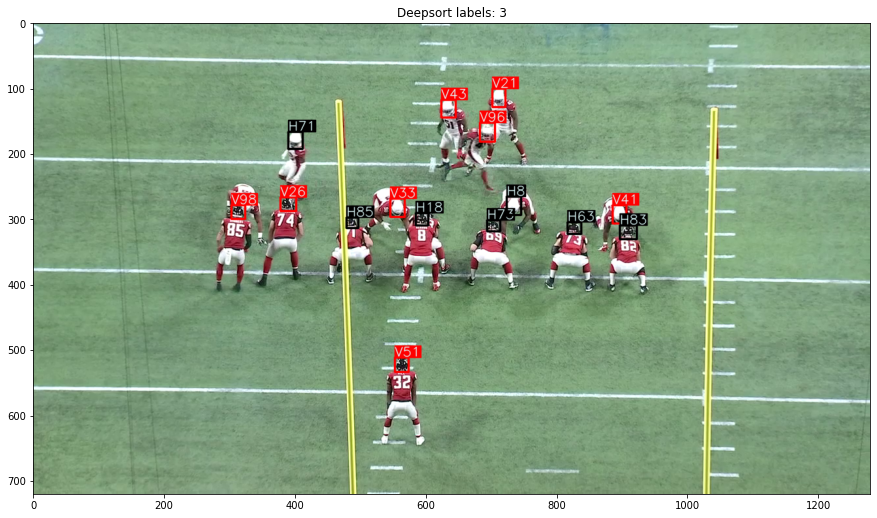

 50%|█████     | 1/2 [00:00<00:00,  2.62it/s]

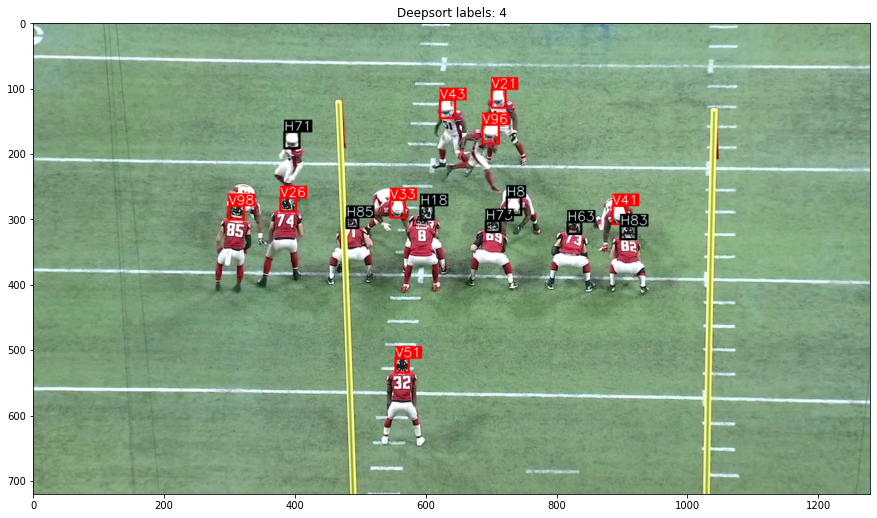

100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


In [22]:
@noglobal()
def compute_color_for_id(label):
    """
    Simple function that adds fixed color depending on the id
    """
    palette = (2 ** 11 - 1, 2 ** 15 - 1, 2 ** 20 - 1)

    color = [int((p * (label ** 2 - label + 1)) % 255) for p in palette]
    return tuple(color)

@noglobal()
def plot_one_box(x, im, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label: 
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return im


base_dir = "/work/data/input/nfl-health-and-safety-helmet-assignment"
video_dir = f"{base_dir}/train/"
myvideo = modify["video"].unique()[0]
#modify= train_df



count = 0
for frame, d in tqdm(modify.groupby(['frame']), total=modify['frame'].nunique()):        
        #if(frame >10 or count > 10):
        #    continue;
        count = count + 1
        xywhs = d[['left','top','right','bottom']].values
        labels = d["player"].values


        cap = cv2.VideoCapture(f'{video_dir}/{myvideo}.mp4')

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # optional

        ##シーケンス
        success, image = cap.read()

        # 画像の色の順番を変更（BGR to RGB）
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        if (True ):



            for j, (output, label) in enumerate(zip(xywhs, labels)): 

                bboxes = output[0:4]
                label = f'{label}'

                #color = compute_color_for_id(label)
                
                
                if ("H" in label):
                    im = plot_one_box(bboxes, image, label=label, color=[0,0,0], line_thickness=2)    
                elif ("V" in label):
                    im = plot_one_box(bboxes, image, label=label, color=[255,0,0], line_thickness=2)    
                else:
                    raise Exception("asdf");



            ig, ax = plt.subplots(figsize=(15, 10))
            video_frame = d['frame'].values[0]
            ax.set_title(f'Deepsort labels: {video_frame}')
            plt.imshow(im)
            plt.show()
